<h1> Fitting for the 5.2 keV line in the RUN03 WS data ... and others</h1>

In [1]:
import sys
import os
sys.path.insert(2, '/global/project/projectdirs/lux/Tools/root_pdsf/root/lib')
from ROOT import TCanvas, TPad, TFile, TPaveText, TChain, TCut, TF1, TH2F, TCutG, TText
from ROOT import gBenchmark, gStyle, gROOT

In [2]:
import rootnotes_nersc
from rootnotes_nersc import rtshow, clearCanvas
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal

In [3]:
%pylab inline  
#always do this for plotting...  don't ask why
#now set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data')
import aLib

<h1> Setup 2D Normal fitting  </h1>

In [5]:
import scipy.optimize as opt
import numpy as np

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [10]:
chain = TChain('golden')
chain.Add('/project/projectdirs/lux/data/golden/Golden_Run03/Golden_150303_WS*.root')

9

<h1> Load in all the LUX Run03 WIMP Search Data </h1>

<h1> Define the S1 and S2 cuts to seperate the islands of energy (see later plots) </h1>

In [7]:
#just using the first array for 5.2 keV in this code... these are polygon cuts.
Energies=[5.2,41.55,163,208,236.8,410,609]
NamesE=["5keV","83Kr-42","163","208","237","410","609"]
cutsx=[[log10(1400),log10(1400),log10(2600),log10(2600)],
           [3.6,3.6,4.4,4.4],
           [4.6,4.6,4.9,4.9], 
           [4.7,4.7,4.95,4.95], 
           [4.7,4.7,5.05,5.05], 
           [5.02,5.02,5.3,5.25], 
           [5.3,5.3,5.5,5.5]]

cutsy=[[1,log10(40),log10(40),1],
           [2.2,2.6,2.6,2.2],
           [2.9,3.1,2.9,2.8], 
           [3.05,3.15,3.0,2.9], 
           [3.1,3.25,3.1,2.95], 
           [3.35, 3.5, 3.3, 3.2], 
           [3.4,3.63,3.43,3.25]]

mean_s2=zeros(len(Energies))
mean_s2_sig=zeros(len(Energies))
mean_s1=zeros(len(Energies))
mean_s1_sig=zeros(len(Energies))

<h3> Analysis for the 5.2 keV line. Extending radius to 23.5cm. Define cuts and make 2D histogram in root </h3>

In [11]:
c3 = rootnotes_nersc.default_canvas(name='X-ray')

In [12]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<23.5')
area_cut=TCut('s1area>10**1 && s1area<10**4 && s2area_raw>150 && s2area>10**2 && s2area<10**6')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

In [13]:
chain.SetMarkerStyle(7)
chain.SetMarkerSize(10)
density_plt_hst=TH2F('density_plt_hst','5.2 keV x-ray 1;S2_{c};s1_{c}',20,1000,3500,20,10,50)
#density_plt_hst.Draw()
chain.Draw('s1area:s2area>>density_plt_hst',fid_vol+area_cut+bad_area_cut,'colz')

3067458L

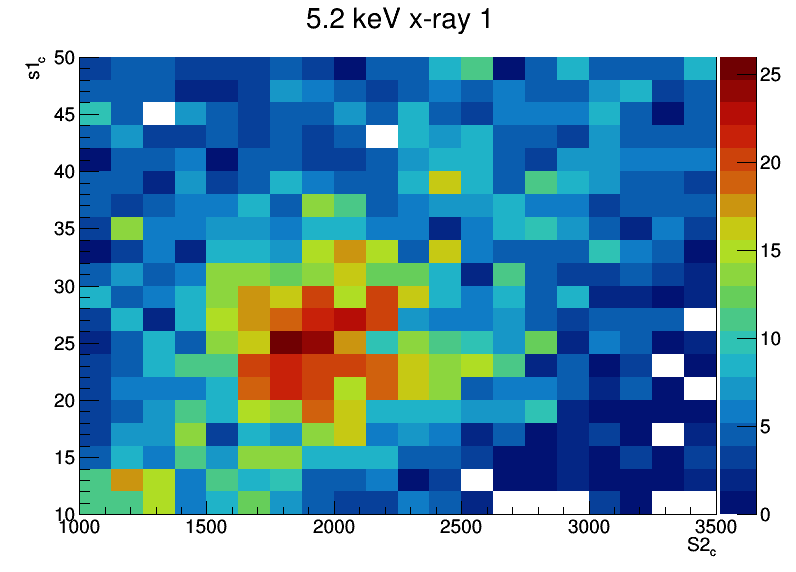

In [14]:
c3.SetLogz(0)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(100)
#c3.SaveAs('5keV.pdf') # in your scratch space on NERSC
rtshow(c3) # this prints the plot

<h1> Now apply the box cut around the polulation for 2D normal fitting </h1>

In [15]:
E_cut=TCut('(s1area>10 && s1area<40 && s2area>1400 && s2area<2600)')

In [18]:
density_plt_hst=TH2F(NamesE[0],NamesE[0]+';S2_{c};S1_{c}',20,1000,3500,20,10,50)
combined_cut=TCut(E_cut.GetTitle() + '&&'+ fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())
n=chain.Draw('s1area:s2area>>'+NamesE[0],combined_cut + combined_cut,'colz')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: 5keV (Potential memory leak).


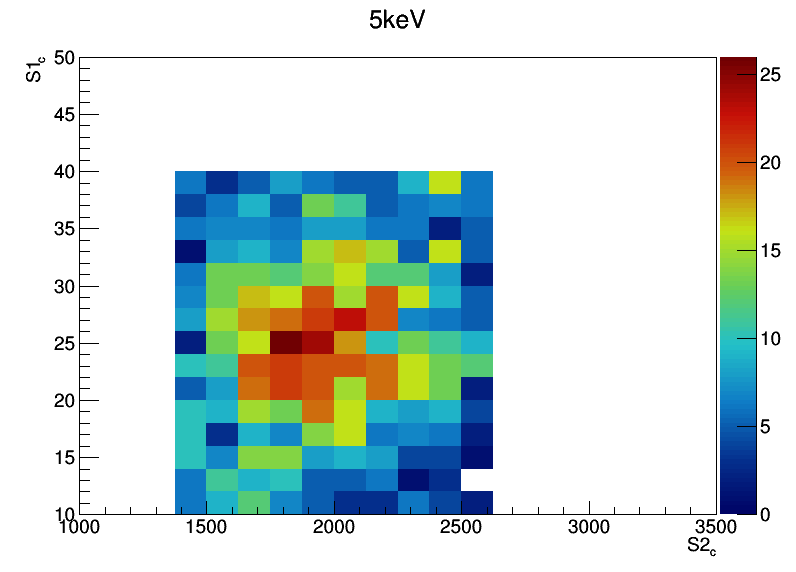

In [19]:
rtshow(c3) #draw the cut

In [20]:
n

1514L

<h1>Import the data from root tree into an numpy array </h1>

In [21]:
s1 = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
s2 = ndarray( (n,),dtype= float64, buffer=chain.GetV2())

<h1> Create the 2D histogram </h1>

In [22]:
H, xedges, yedges = histogram2d(s2, s1, bins=10, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

<matplotlib.colorbar.Colorbar instance at 0x7fc7437310e0>

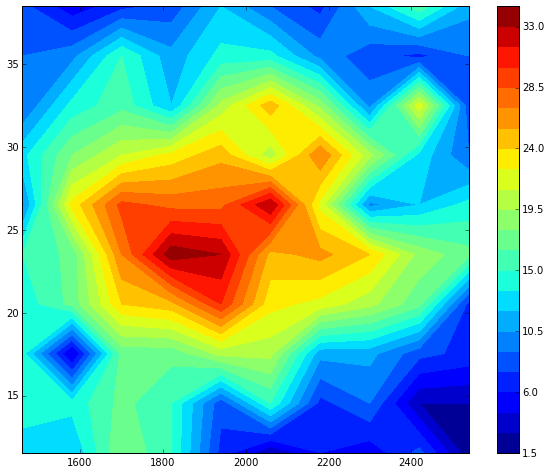

In [23]:
# plot the result of the histogram
plt.contourf(x_bin_center,y_bin_center,H,25)
plt.colorbar()

<h1> Fit 2D normal to the histogram </h1>

In [24]:
initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2[0]=popt[1]
mean_s2_sig[0]=sqrt(pcov[1,1])
mean_s1[0]=popt[2]
mean_s1_sig[0]=sqrt(pcov[2,2])

In [25]:
popt

array([  2.48087411e+01,   1.93588560e+03,   2.49499532e+01,
         3.36123684e+02,   6.56328538e+00,  -3.52316213e-03,
         6.50345961e+00])

In [ ]:
# Save the fits to a txt file
#savetxt('5keVfit.txt', popt, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
#savetxt('5keVcov.txt', pcov, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')

<h1> Plot the result of the 2D normal fit </h1>

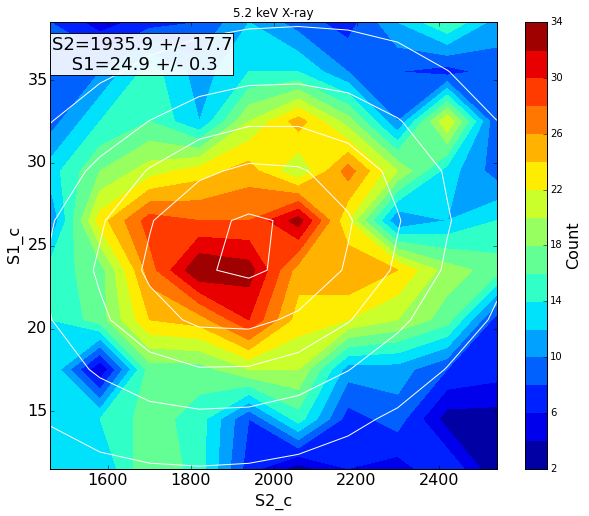

In [26]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,20)
ax.contour(x, y, data_fitted.reshape(x.shape), 5, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.min()*1.15,y.max()*.95,'S2={:1.1f} +/- {:1.1f} \n S1={:1.1f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('5.2 keV X-ray')
#savefig('5keV_fit.pdf') #save to your scratch space in NERSC

<h1> Set up a new canvas and make a density plot of all the data from RUN03 that goes into the Doke plot </h1>

In [27]:
c4 = rootnotes_nersc.default_canvas(name='WS')

In [28]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<20')

In [29]:
area_cut=TCut('s1area>10**1 && s1area<10**4 && s2area_raw>150 && s2area>10**2 && s2area<10**6')

In [30]:
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst (Potential memory leak).


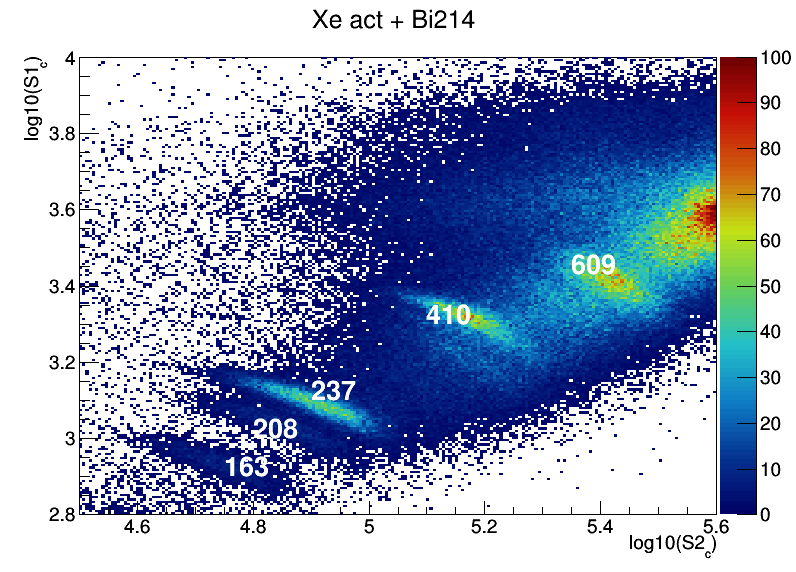

In [33]:
# Make the S2 vs S1 density plot for the WS data

#density_plt_hst=TH2F('density_plt_hst','Run03 WS -Golden ;log10(S2_{c});log10(S1_{c})',300,3.5,5.6,300,2,4) #include Kr
density_plt_hst=TH2F('density_plt_hst','Xe act + Bi214 ;log10(S2_{c});log10(S1_{c})',200,4.5,5.6,200,2.8,4) #include Kr

chain.Draw('log10(s1area):log10(s2area)>>density_plt_hst',fid_vol+area_cut+bad_area_cut,'colz')

#add text for energies in the plot
tt=[]# make an empty list for text files
for ii, xx in enumerate(Energies[2:]):
    tt.append(TText(cutsx[ii+2][3]-.15,cutsy[ii+2][2],NamesE[ii+2]))
    tt[ii].SetTextColor(0)
    tt[ii].Draw()

c4.SetLogz(0)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(100)
rtshow(c4)
#c4.SaveAs('Run03Golden.pdf') # save the figure

<h1 style='color:red;'>Loop through all the lines to calcualte the mean S1 and S2 <br/> Set j=1 to 6 and select "run all below in the "cell" menu... and poof a result will appear at the bottom </h1> 

In [36]:
jj=1 # start with Kr at 1 (the second entry) and go to 6 (Bi214). Hit the "Run ALL CELLS BELOW" button

In [37]:
E_cut=TCutG("E_cut",4,array(cutsx[jj]),array(cutsy[jj]))
E_cut.SetVarX('log10(s2area)')
E_cut.SetVarY('log10(s1area)')

In [38]:
density_plt_hst=TH2F('density_plt_hst',NamesE[jj]+';log10(S2_{c});log10(S1_{c})',300,3.5,5.6,300,2,4) #include Kr
combined_cut=TCut('E_cut' + '&&'+ fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())
n=chain.Draw('log10(s1area):log10(s2area)>>density_plt_hst',combined_cut,'colz')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst (Potential memory leak).


In [39]:
#E_cut.Draw()

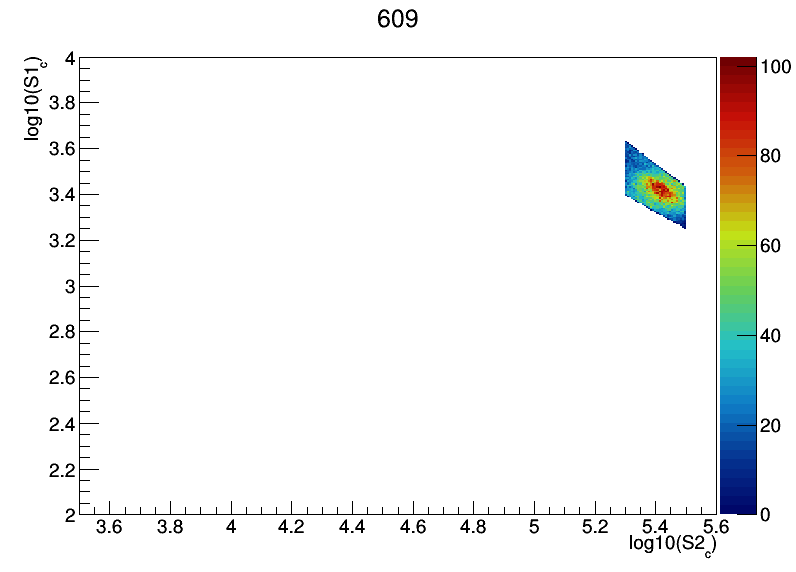

In [40]:
c4.SetLogz(0)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(50)
rtshow(c4) # this command lets you view the cut
#c4.SaveAs('Run03_Golden_Doke/{:s}.pdf'.format(NamesE[jj])) #save image to your scratch, or add a path

<h1> import the root data to a numpy array </h1>

In [41]:
if n>2e5:
    n=2e5
    
s1 = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
s2 = ndarray( (n,),dtype= float64, buffer=chain.GetV2())
s1=10**s1
s2=10**s2

In [42]:
H, xedges, yedges = histogram2d(s2, s1, bins=20, range=None, normed=False)
H=H.T # need to trasnpose to stay consistent with x,y dimensions. Otherwise flip x and y in histogram2d
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2
#plt.contourf(x_bin_center,y_bin_center,H,20) # view result

<h1> Fit the data </h1>

In [43]:
initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2[jj]=popt[1]
mean_s2_sig[jj]=sqrt(pcov[1,1])
mean_s1[jj]=popt[2]
mean_s1_sig[jj]=sqrt(pcov[2,2])

In [44]:
#save the results of the fit
#savetxt('Run03_Golden_Doke/fits/{:s}keVfit.txt'.format(NamesE[jj]), popt, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
#savetxt('Run03_Golden_Doke/fits/{:s}keVcov.txt'.format(NamesE[jj]), pcov, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')

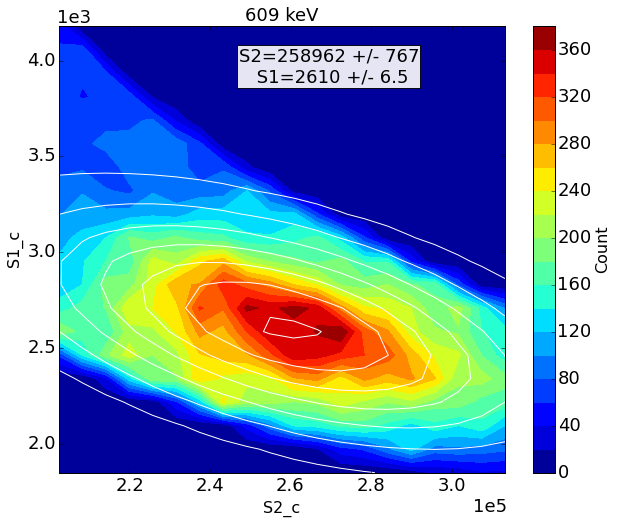

In [45]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,20)
ax.contour(x, y, data_fitted.reshape(x.shape), 7, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
plt.ticklabel_format(style='sci',axis='both',scilimits=(0,0),fontsize=16)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes

cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.max()*.86,y.max()*.95,'S2={:1.0f} +/- {:1.0f} \n S1={:1.0f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('{:s} keV'.format(NamesE[jj]),fontsize=18)
#savefig('Run03_Golden_Doke/{:s}_fit.pdf'.format(NamesE[jj])) #save the figure to path/folder/

In [46]:
#savetxt('s2_and_s1_means.txt',[mean_s2,mean_s2_sig,mean_s1,mean_s1_sig]) #write the results of the fits to a file
# view results for means, [mean_s2,mean_s2_sig,mean_s1,mean_s1_sig]). Same size as the Energies vector

In [ ]:
clearCanvas()